<a href="https://colab.research.google.com/github/rodjfg/los-fabulosos-pixelotls/blob/master/Left_Rigth_model_Flor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Left / Right model

In [1]:
!pip install --quiet git+https://github.com/rodjfg/los-fabulosos-pixelotls

In [2]:
from los_fabulosos_pixelotls.tools import load_raw_data, select_by_areas, select_by_contrast, select_trials, calculate_mean_firing_rate, select_by_response
import numpy as np
from matplotlib import rcParams 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
# get data
alldat = load_raw_data()

In [4]:
selected_regions = ["VISp"]
gaussfilter = True
gauss_sigma = 1

samples = np.empty((0,250))
norm_samples = np.empty((0,250))
y = np.empty((0,))


for dat in alldat:
  dt = dat['bin_size']

  neurons_indices_in_area = select_by_areas(dat, selected_regions = selected_regions)
  #Mean responses hole brain
  mean_spikes_per_brain = np.mean(dat['spks'][neurons_indices_in_area])/dt
  std_spikes_per_brain = np.std(dat['spks'][neurons_indices_in_area])/dt

  if len(neurons_indices_in_area) > 0:

    right_response_trials = select_by_response(dat, response_type = 'to_left') # trials in which mouse should move to the left (higher contrast on right side)
    left_response_trials = select_by_response(dat, response_type = 'to_right') # trials in which mouse should move to the right (higher contrast on left side)

    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the left
    right_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,right_response_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)
    norm_right_firing_rates = (right_firing_rates - mean_spikes_per_brain)/std_spikes_per_brain
    
    # average firing rate across neuron population (e.g. VISp) for each trial in which mouse moved to the right
    left_firing_rates = calculate_mean_firing_rate(dat['spks'][neurons_indices_in_area][:,left_response_trials], dt, ['population'], gaussfilter = gaussfilter, gauss_sigma = gauss_sigma)
    norm_left_firing_rates = (left_firing_rates - mean_spikes_per_brain)/std_spikes_per_brain

    # find minimum number of samples that can be extracted from both conditions
    n_min = min(right_firing_rates.shape[0],left_firing_rates.shape[0])
    samples = np.concatenate((samples,right_firing_rates[:n_min,...]),axis=0)
    samples = np.concatenate((samples,left_firing_rates[:n_min,...]),axis=0)

    #Normalised samples
    norm_samples = np.concatenate((norm_samples,norm_right_firing_rates[:n_min,...]),axis=0)
    norm_samples = np.concatenate((norm_samples,norm_left_firing_rates[:n_min,...]),axis=0)

    # 1: mouse moved to the left, 0: mouse moved to the right
    y = np.concatenate( (y, np.ones(n_min)) )
    y = np.concatenate( (y, np.zeros(n_min)) )

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
y.shape, samples.shape

((1962,), (1962, 250))

In [6]:
y.shape, norm_samples.shape

((1962,), (1962, 250))

In [7]:
np.allclose(samples,norm_samples)

False

TRAIN AND TEST SPLIT

In [8]:
samples_train, samples_test, y_train, y_test = train_test_split(samples, y, test_size=0.23, random_state=42)

In [9]:
samples_train_norm, samples_test_norm, y_train, y_test = train_test_split(norm_samples, y, test_size=0.23, random_state=42)

In [10]:
# C: float, default=1.0, Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

# clf = LogisticRegressionCV(Cs=5, cv=4, penalty='l2', tol=0.0001, max_iter=5000, random_state=42).fit(samples_train, y_train)
clf = LogisticRegression(penalty='l2', C =0.1, solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_train, y_train)
clf_norm = LogisticRegression(penalty='l2', C =0.1, solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_train_norm, y_train)

In [12]:
print('***Train***')
print('Score:', clf.score(samples_train,y_train))
print('Norm_Score:',clf_norm.score(samples_train_norm,y_train))

print('***Test***')
print('Score:',clf.score(samples_test,y_test))
print('Norm_Score:',clf_norm.score(samples_test_norm,y_test))

***Train***
Score: 0.6788079470198676
Norm_Score: 0.6437086092715232
***Test***
Score: 0.5685840707964602
Norm_Score: 0.5995575221238938


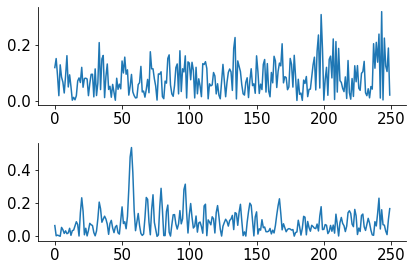

In [13]:
plt.subplot(211)
plt.plot(np.abs(clf.coef_[0,:]))
plt.subplot(212)
plt.plot(np.abs(clf_norm.coef_[0,:]))
plt.show()

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

In [ ]:
print('********TEST**********Regresion Logistica*********TEST***********')
#Evaluacion en test
scores_test = cross_val_score(lr, X_test, t_test, cv=5, scoring="accuracy") #evaluo este ajuste con cv
print('test >>> Media accuracy score con cv:', scores_test.mean())
y_test_lr = cross_val_predict(lr, X_test, t_test, cv=5) #predicciones en el train con cv (luego matrix conf)
cm_lr_test = confusion_matrix(t_test, y_test_lr)
print('test >>> Matriz de confusion RLog:')
print(cm_lr_test)
print("test >>> Precision RLog:",precision_score(t_test, y_test_lr))
print("test >>> Recall RLog:",recall_score(t_test, y_test_lr))

In [71]:
def clasificator_analisis(model, X, y):
  '''Compute accuracy with CV, confusion matrix, precision-recall scores and plot ROC and precision-recall curves.
   Args: 
     model = model object trained from sklearn
         X = input features in train or test
         y = target in train or test
   Return:
    Print of all the scores computed and save accuracy, cm, precision, recall
'''
  
  from sklearn.model_selection import cross_val_predict, cross_val_score
  from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve

  accu = cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
  print(f'{model} \nAccuracy:{accu}\n')
  pred = cross_val_predict(model, X, y, cv=5)
  cm = confusion_matrix(y,pred)
  print(f'Confusion Matrix: \n {cm}\n')
  precision = precision_score(y,pred)
  print('Precision:',precision)
  recall = recall_score(y, pred)
  print('Recall:', recall)
  plot_precision_recall_curve(model, X, y)
  plt.show()

  plot_roc_curve(model, X, y)
  plt.plot([0, 1], [0, 1], color='0.5', ls=':')
  plt.show()
  
  #return accu, cm, precision, recall

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=8000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy:0.5552380952380952

Confusion Matrix: 
 [[151  93]
 [108 100]]

Precision: 0.5181347150259067
Recall: 0.4807692307692308


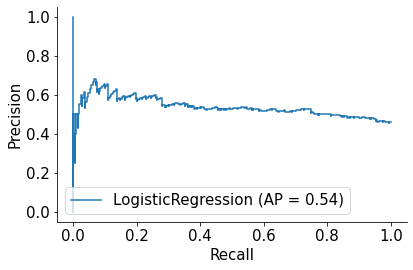

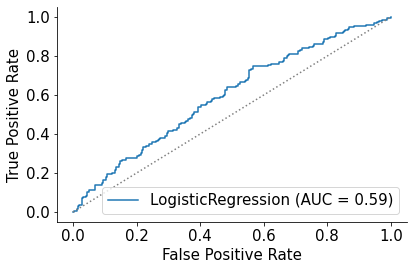

In [72]:
clasificator_analisis(clf,samples_test,y_test )

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=8000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False) 
Accuracy:0.5684981684981685

Confusion Matrix: 
 [[199  45]
 [150  58]]

Precision: 0.5631067961165048
Recall: 0.27884615384615385


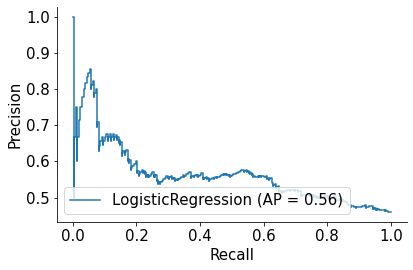

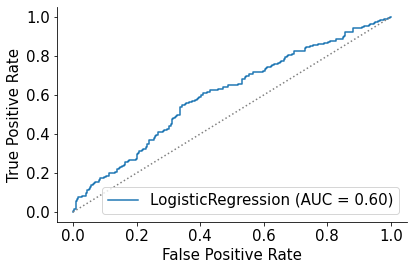

In [64]:
b =clasificator_analisis(clf_norm,samples_test_norm,y_test)

In [23]:
print(a)

[0.5552380952380952]


In [ ]:
classifiers = [perce, lr]
ax = plt.gca()
for i in classifiers:
    plot_precision_recall_curve(i, X_train, t_train, ax=ax)
plt.title('Train set')
plt.show()

In [ ]:
precisions_p, recalls_p, thresholds_p = precision_recall_curve(t_train, y_train_perce)
fpr_p, tpr_p, thresholds_p = roc_curve(t_train, y_train_perce)
print('ROC AUC perceptron:',roc_auc_score(t_train, y_train_perce))

precisions_lr, recalls_lr, thresholds_lr = precision_recall_curve(t_train, y_train_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(t_train, y_train_lr)
print('ROC AUC Reg Logistica:',roc_auc_score(t_train, y_train_lr))

classifiers = [perce, lr]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_train, t_train, ax=ax)
    plt.plot([0, 1], [0, 1], color='0.5', ls=':')
plt.title('Train set')
plt.show()

In [35]:
LogisticRegressionCV?

In [13]:
clf_CV = LogisticRegressionCV(Cs=10, penalty='l1', solver='saga', tol=0.0001, max_iter=8000, random_state=42).fit(samples_train, y_train)
clf_CV.score(samples_test,y_test)

0.581858407079646

In [16]:
clf_CV.C_

array([0.00599484])